# Lab3: Clustering with K-means, K-means++ and Kmedioids

## Overview
In this lab, you will learn how to implement and analyze the **K-means**, **K-means++**  and **Kmedioids** clustering algorithms on two different real-world datasets:

- **MNIST Digits** (10 handwritten digits (image)).  
- **CIFAR-10 dataset** (different categories of imagenet style objects).  

You will compare the performance of **K-means**,  **K-means++** and **Kmedioids**.

Note that everywhere you need to use random_state = 42 where ever needed for Kmeans, Kmeans++ and Kmedioids for reproducibility, if you set this to anotehr value **you will not get full score**.


In [9]:
# Clean imports (no sklearn-extra, use pyclustering for KMedoids instead)
!pip install -q datasets pyclustering pillow seaborn pandas matplotlib

from datasets import load_dataset
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from PIL import Image  # for .resize on PIL images

from sklearn.metrics import (
    silhouette_score,
    pairwise_distances,
    adjusted_rand_score,
    normalized_mutual_info_score,
    confusion_matrix
)

from collections import Counter
from sklearn.manifold import TSNE


## Dataset MNIST (HandWritten Digits)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/15.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/2.60M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

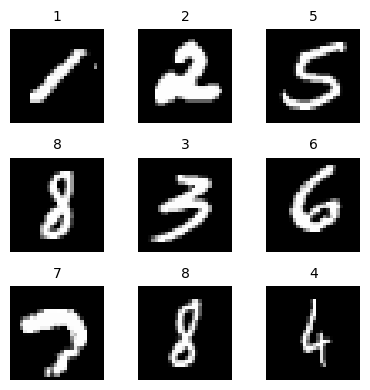

In [10]:
# 1. Load MNIST dataset
dataset = load_dataset("mnist", split="train[:5000]")
dataset = dataset.shuffle(seed=42)

# Show a 3x3 grid of sample images
fig, axes = plt.subplots(3, 3, figsize=(4, 4))

for i, ax in enumerate(axes.flat):
    img = dataset[i]["image"]                 # PIL image
    label = dataset.features["label"].int2str(dataset[i]["label"])
    ax.imshow(img, cmap="gray")               # explicit grayscale colormap
    ax.set_title(label, fontsize=10)
    ax.axis("off")

plt.tight_layout()
plt.show()


In [11]:
# 2. Preprocess: resize + flatten images (MNIST is grayscale)
X = np.array([np.array(img.resize((64, 64))).flatten()
              for img in dataset["image"]], dtype=np.float32)

# Normalize to [0, 1]
X = X / 255.0

print("Data shape:", X.shape)  # (N, 64*64) = (N, 4096)

# PCA for speed & denoising (50–100 is a good sweet spot for MNIST)
pca = PCA(n_components=50, random_state=42)
X = pca.fit_transform(X)
print("After PCA:", X.shape)   # (N, 50)

# 3. Extract labels
y = np.array(dataset["label"])
label_names = dataset.features["label"].names
print("Labels shape:", y.shape)

# 4. Count unique classes (ground truth, not clusters)
unique_labels, counts = np.unique(y, return_counts=True)
n_classes = len(unique_labels)
print("\nNumber of classes:", n_classes)
print("Class distribution:")
for i in range(n_classes):
    print(f"{unique_labels[i]} -> {label_names[unique_labels[i]]} ({counts[i]} samples)")


Data shape: (5000, 4096)
After PCA: (5000, 50)
Labels shape: (5000,)

Number of classes: 10
Class distribution:
0 -> 0 (479 samples)
1 -> 1 (563 samples)
2 -> 2 (488 samples)
3 -> 3 (493 samples)
4 -> 4 (535 samples)
5 -> 5 (434 samples)
6 -> 6 (501 samples)
7 -> 7 (550 samples)
8 -> 8 (462 samples)
9 -> 9 (495 samples)


In [14]:
def show_closest_images(X, dataset, centroids, labels, title, num_images=5):
    """
    X: features used for clustering (e.g., after PCA), shape (N, d)
    centroids: array of shape (k, d) (use cluster centers or X[medoid_ids])
    labels: predicted cluster labels (e.g., kmeans.labels_), length N
    """
    X = np.asarray(X)
    centroids = np.asarray(centroids)
    labels = np.asarray(labels)

    k = centroids.shape[0]
    assert X.shape[1] == centroids.shape[1], "Centroids must be in same feature space as X."

    # Make subplot grid; handle 1-row/1-col edge cases
    fig, axes = plt.subplots(k, num_images, figsize=(1.2*num_images, 1.2*k))
    if k == 1 and num_images == 1:
        axes = np.array([[axes]])
    elif k == 1:
        axes = axes[np.newaxis, :]
    elif num_images == 1:
        axes = axes[:, np.newaxis]

    for i in range(k):
        # distances from cluster i centroid to all points
        d = np.linalg.norm(X - centroids[i], axis=1)
        cluster_idx = np.where(labels == i)[0]
        if cluster_idx.size == 0:
            # no points in this cluster; blank row
            for j in range(num_images):
                axes[i, j].axis("off")
            continue

        # pick up to num_images closest points from this cluster
        take = min(num_images, cluster_idx.size)
        closest = cluster_idx[np.argsort(d[cluster_idx])[:take]]

        for j in range(num_images):
            ax = axes[i, j]
            if j < take:
                idx = int(closest[j])
                img = dataset[idx]["image"]
                ax.imshow(img, cmap="gray")
                ax.axis("off")
                # small true label under the image (optional)
                lbl = dataset.features["label"].int2str(dataset[idx]["label"])
                ax.text(0.5, -0.15, lbl, size=7, ha="center", va="top", transform=ax.transAxes)
            else:
                ax.axis("off")

        axes[i, 0].set_title(f"Cluster {i}", fontsize=9)

    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()


# [TODO] Implement KMeans for MNIST (2 points)

## Instructions

In this section, you will implement **K-means** using the **sklearn** library.

- Use the `KMeans` class from `sklearn.cluster`.
- Set the following parameters:
  - `n_clusters = k` (choose based on the dataset what do you think thge right number is for this dataset?).  
  - `init = "?"` what should this be for Kmeans?.  
  - `n_init = 10` (please set the number of random initializations to 10).  
  - `max_iter = 50` (maximum number of iterations before convergence need to be set to 50).  
  - `random_state = 42` (for reproducibility).  

Note that everywhere you need to use random_state = 42 where ever needed for Kmeans, Kmeans++ and Kmedioids for reproducibility, if you set this to another value **you will not get full score**.

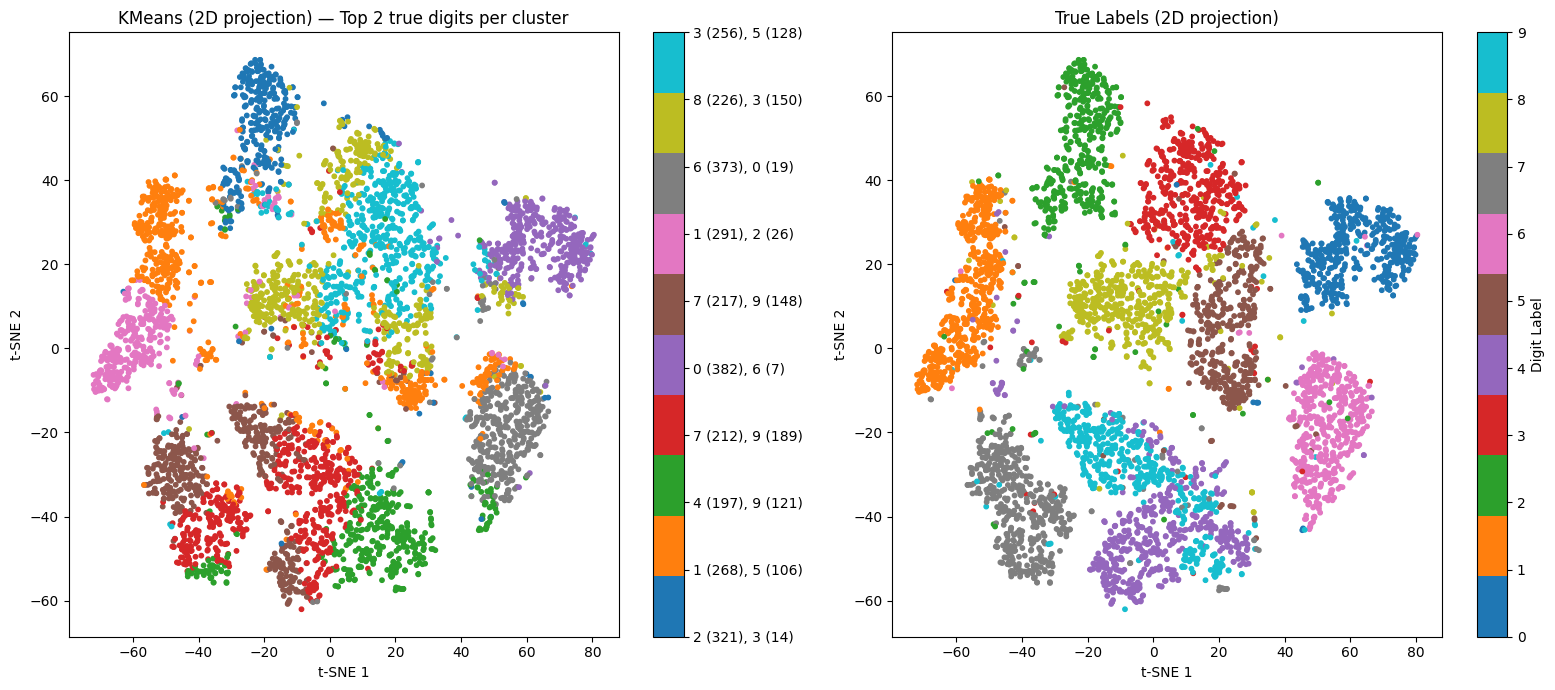

In [15]:
# ----------------------------
# TODO Implement KMeans
# ----------------------------

from sklearn.cluster import KMeans
from collections import Counter

# number of clusters = number of digit classes in MNIST (10)
k = len(np.unique(y))  # should be 10

# Plain KMeans (random init) per lab instructions
kmeans_rand = KMeans(
    n_clusters=k,
    init="random",      # plain KMeans (vs. k-means++)
    n_init=10,          # number of random initializations
    max_iter=50,        # maximum iterations
    random_state=42     # DO NOT change (reproducibility)
)
kmeans_rand.fit(X)

labels_km  = kmeans_rand.labels_              # predicted cluster labels
centers_km = kmeans_rand.cluster_centers_     # cluster centroids in PCA space

# ----------------------------
# Implementation ends here
# ----------------------------


# =============== Visualization (2D with t-SNE) ===============
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Reduce features to 2D for visualization only
X_2d = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(X)

# Build colorbar tick labels showing top-2 true digits per cluster
tick_labels = []
for cluster_id in range(k):
    idxs = np.where(labels_km == cluster_id)[0]
    true_labels = y[idxs]
    if len(true_labels) > 0:
        counts = Counter(true_labels).most_common(2)
        if len(counts) == 1:
            label_str = f"{counts[0][0]} ({counts[0][1]})"
        else:
            label_str = f"{counts[0][0]} ({counts[0][1]}), {counts[1][0]} ({counts[1][1]})"
        tick_labels.append(label_str)
    else:
        tick_labels.append("Empty")

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Left: KMeans clusters (predicted)
sc1 = axes[0].scatter(X_2d[:, 0], X_2d[:, 1], c=labels_km, cmap="tab10", s=10)
cbar1 = plt.colorbar(sc1, ax=axes[0], ticks=range(k))
cbar1.ax.set_yticklabels(tick_labels)
axes[0].set_title("KMeans (2D projection) — Top 2 true digits per cluster")
axes[0].set_xlabel("t-SNE 1")
axes[0].set_ylabel("t-SNE 2")

# Right: True labels
sc2 = axes[1].scatter(X_2d[:, 0], X_2d[:, 1], c=y, cmap="tab10", s=10)
cbar2 = plt.colorbar(sc2, ax=axes[1])
cbar2.set_label("Digit Label")
axes[1].set_title("True Labels (2D projection)")
axes[1].set_xlabel("t-SNE 1")
axes[1].set_ylabel("t-SNE 2")

plt.tight_layout()
plt.show()


# [TODO]: Find Confused Digit Pairs in Kmeans (1 point)

- For each cluster, check the **second most common true label**.  
- If its count is **greater than 50**, record the pairs (most common, second most common) and write your answer here.

Answer: [TODO]


In [ ]:
show_closest_images(X, dataset, centroids_km, labels_km, "K-means")

# [TODO] Implement KMeans++ for MNIST (2 points)

## Instructions

In this section, you will implement **K-means ++** using the **sklearn** library.

- Use the `KMeans` class from `sklearn.cluster`.
- Set the following parameters:
  - `n_clusters = k` (choose based on the dataset what do you think thge right number is for this dataset?).  
  - `init = "?"` what should this be for Kmeans ++ ?.  
  - `n_init = 10` (please set the number of random initializations to 10).  
  - `max_iter = 50` (maximum number of iterations before convergence need to be set to 50).  
  - `random_state = 42` (for reproducibility).  

Note that everywhere you need to use random_state = 42 where ever needed for Kmeans, Kmeans++ and Kmedioids for reproducibility, if you set this to anotehr value **you will not get full score**.

Confused digit pairs (most, second, second_count, cluster_id):
[(np.int64(1), np.int64(5), 106, 1), (np.int64(4), np.int64(9), 121, 2), (np.int64(7), np.int64(9), 189, 3), (np.int64(7), np.int64(9), 148, 5), (np.int64(8), np.int64(3), 150, 8), (np.int64(3), np.int64(5), 128, 9)]


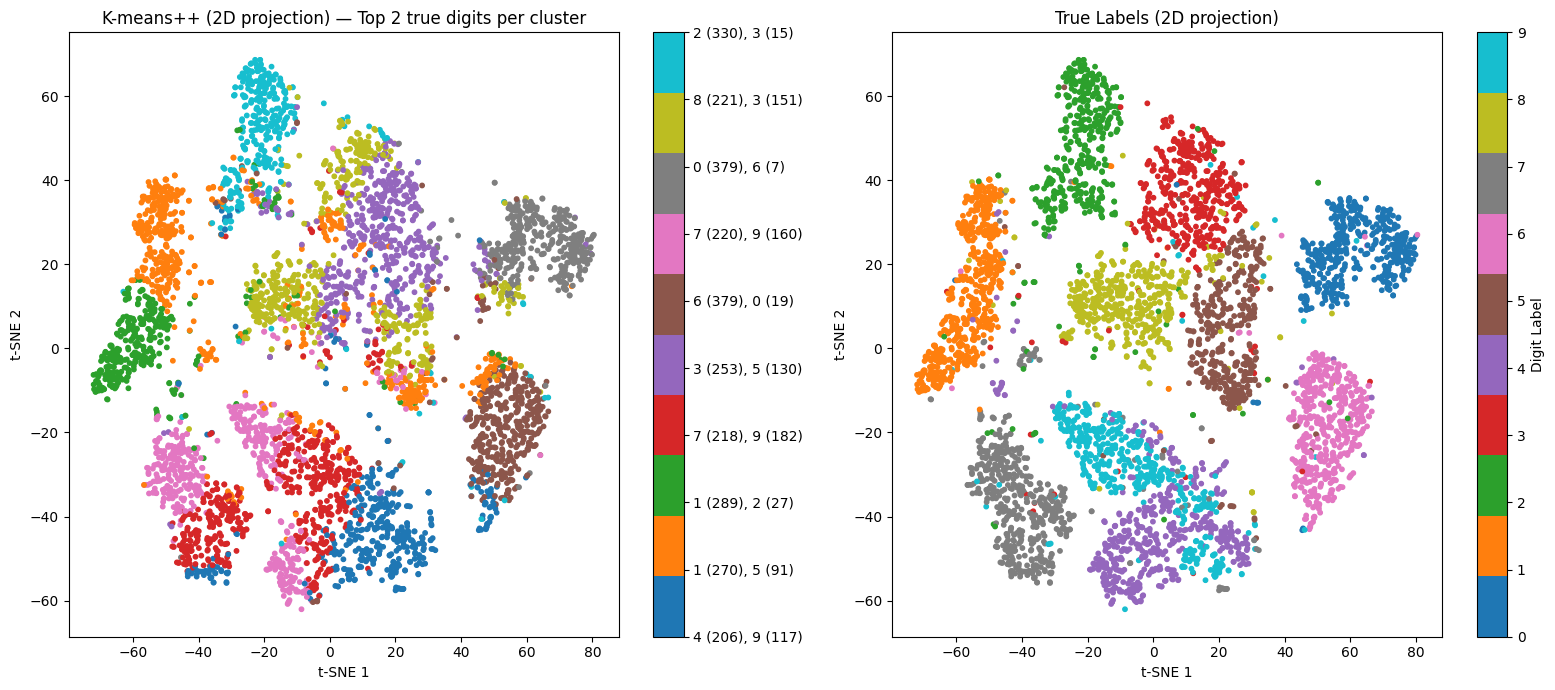

In [16]:
# ----------------------------
# TODO Implement Kmeans ++
# ----------------------------
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

# number of clusters (10 for MNIST)
k = len(np.unique(y))

# ---- Train K-means++ ----
kmeans_pp = KMeans(
    n_clusters=k,
    init="k-means++",   # K-means++ initializer
    n_init=10,
    max_iter=50,
    random_state=42
)
kmeans_pp.fit(X)

labels_pp    = kmeans_pp.labels_           # predicted labels (K-means++)
centroids_pp = kmeans_pp.cluster_centers_  # centroids (in PCA space)

# ----------------------------
# Implementation ends here
# ----------------------------


# ======= (Optional) Answer for "Find Confused Digit Pairs in Kmeans" =======
# Uses the *plain KMeans* results (labels_km) as the question states.
# For each cluster, find top-2 true labels and keep if the second has count > 50.
confused_pairs = []
for c in range(k):
    idxs = np.where(labels_km == c)[0]  # labels_km from the earlier KMeans (random init) section
    if idxs.size == 0:
        continue
    top2 = Counter(y[idxs]).most_common(2)
    if len(top2) == 2 and top2[1][1] > 50:
        most, second = top2[0], top2[1]
        # record: (most_common_digit, second_most_common_digit, second_count, cluster_id)
        confused_pairs.append((most[0], second[0], second[1], c))

print("Confused digit pairs (most, second, second_count, cluster_id):")
print(confused_pairs)


# =============== Visualization of K-means++ (2D with t-SNE) ===============
X_2d = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(X)

# Build colorbar tick labels showing top-2 true digits per cluster (for K-means++)
tick_labels_pp = []
for cluster_id in range(k):
    idxs = np.where(labels_pp == cluster_id)[0]
    true_labels = y[idxs]
    if len(true_labels) > 0:
        counts = Counter(true_labels).most_common(2)
        if len(counts) == 1:
            label_str = f"{counts[0][0]} ({counts[0][1]})"
        else:
            label_str = f"{counts[0][0]} ({counts[0][1]}), {counts[1][0]} ({counts[1][1]})"
        tick_labels_pp.append(label_str)
    else:
        tick_labels_pp.append("Empty")

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Left: K-means++ clusters (predicted)
sc1 = axes[0].scatter(X_2d[:, 0], X_2d[:, 1], c=labels_pp, cmap="tab10", s=10)
cbar1 = plt.colorbar(sc1, ax=axes[0], ticks=range(k))
cbar1.ax.set_yticklabels(tick_labels_pp)
axes[0].set_title("K-means++ (2D projection) — Top 2 true digits per cluster")
axes[0].set_xlabel("t-SNE 1")
axes[0].set_ylabel("t-SNE 2")

# Right: True labels
sc2 = axes[1].scatter(X_2d[:, 0], X_2d[:, 1], c=y, cmap="tab10", s=10)
cbar2 = plt.colorbar(sc2, ax=axes[1])
cbar2.set_label("Digit Label")
axes[1].set_title("True Labels (2D projection)")
axes[1].set_xlabel("t-SNE 1")
axes[1].set_ylabel("t-SNE 2")

plt.tight_layout()
plt.show()




# [TODO]: Find Confused Digit Pairs  in Kmeans++ (1 point)

- For each cluster, check the **second most common true label**.  
- If its count is **greater than 50**, record the pair (most common, second most common) and write your answer here.

Answer: [TODO]

In [ ]:
show_closest_images(X, dataset, centroids_pp, labels_pp, "K-means++")

# [TODO] Implement Kmedioids (2 points)

## Instructions
KMedoids (with `kmedoids` package)

- Use the `KMedoids` class from the **`kmedoids`** package, which you must have pip installed at the start of the notebook.  
- Set the following parameters:
  - `n_clusters = k` → number of clusters (choose based on dataset).  
  - `method = "fasterpam"` → efficient implementation of the PAM algorithm.  
  - `metric = "precomputed"` → pass a precomputed distance matrix.  
  - `random_state = 42` → ensures reproducibility.  
Note that everywhere you need to use random_state = 42 where ever needed for Kmeans, Kmeans++ and Kmedioids for reproducibility, if you set this to anotehr value **you will not get full score**.

Extra Note:  Before running KMedoids, you need to compute a **distance matrix** using e.g.  
  ```python
dist_matrix = pairwise_distances(X, metric="manhattan")



/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


K-Medoids Silhouette: 0.0427


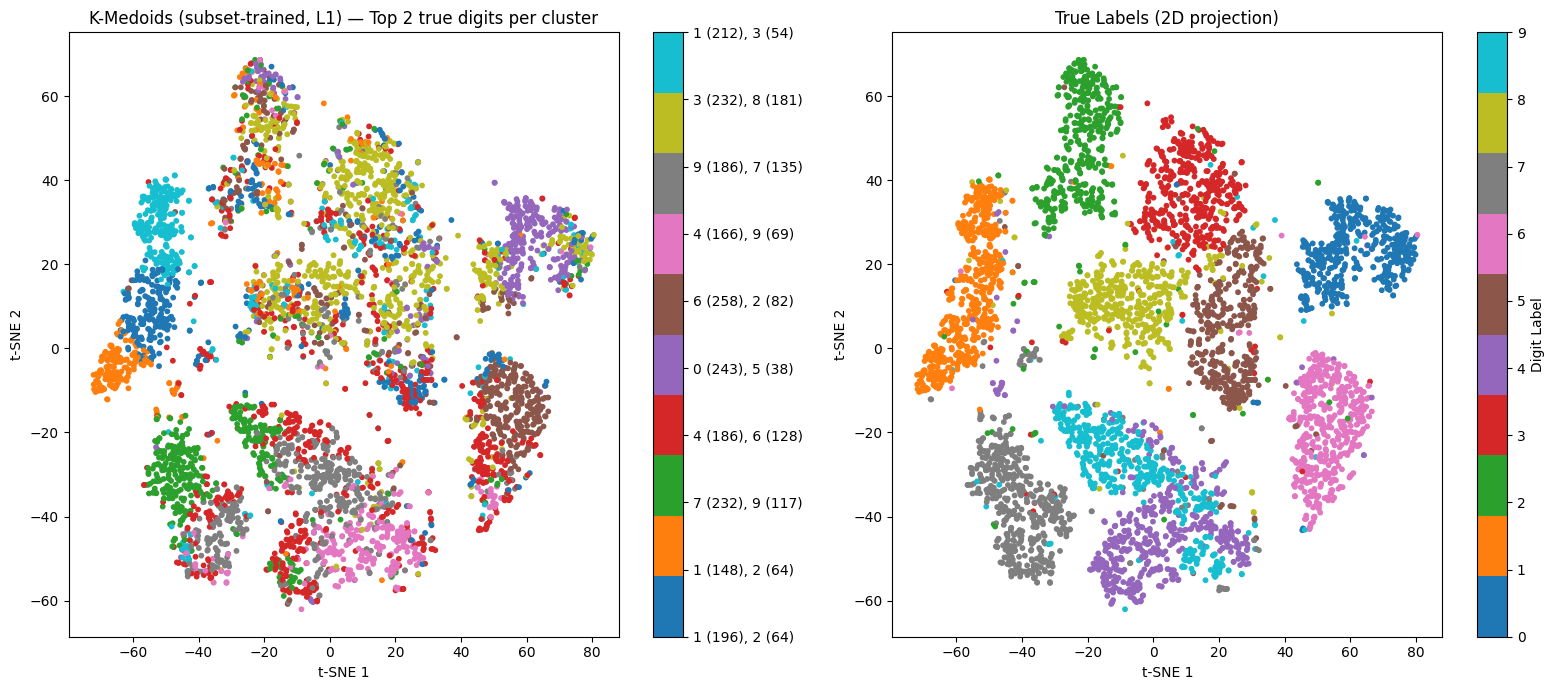

In [3]:
# =========================
# K-Medoids (subset + assign-all) — self-contained & robust
# =========================
# 1) deps (safe to re-run)
!pip -q install pyclustering pillow datasets

import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# 2) Build X, y if missing
if 'X' not in globals() or 'y' not in globals():
    from datasets import load_dataset
    from PIL import Image
    from sklearn.decomposition import PCA

    try:
        dataset
    except NameError:
        dataset = load_dataset("mnist", split="train[:5000]").shuffle(seed=42)

    # resize (64x64) -> flatten -> normalize
    X = np.array([np.array(img.resize((64, 64))).flatten()
                  for img in dataset["image"]], dtype=np.float32) / 255.0
    y = np.array(dataset["label"])

    # PCA for speed/denoising
    pca = PCA(n_components=50, random_state=42)
    X = pca.fit_transform(X)

# 3) K-Medoids on subset, then assign all points
from pyclustering.cluster.kmedoids import kmedoids as _kmedoids
from pyclustering.utils.metric import distance_metric, type_metric

k = len(np.unique(y))          # 10 for MNIST
N = X.shape[0]
n_sub = min(1500, N)           # speed-friendly
rng = np.random.default_rng(42)
sub_idx = np.sort(rng.choice(N, size=n_sub, replace=False))
X_sub = X[sub_idx]

init_medoids = rng.choice(n_sub, size=k, replace=False).tolist()
metric = distance_metric(type_metric.MANHATTAN)

km = _kmedoids(X_sub, init_medoids, data_type='points', metric=metric)
km.process()
medoid_ids_sub = np.asarray(km.get_medoids())   # indices w.r.t. subset
medoids = X_sub[medoid_ids_sub]                 # medoid locations (PCA space)

def manhattan_assign(Xfull, med):
    # returns nearest-medoid index per row
    d = np.sum(np.abs(Xfull[:, None, :] - med[None, :, :]), axis=2)  # (N,k)
    return np.argmin(d, axis=1)

labels_kmed = manhattan_assign(X, medoids)

# 4) (Optional) quick silhouette
try:
    from sklearn.metrics import silhouette_score
    print("K-Medoids Silhouette:", round(silhouette_score(X, labels_kmed), 4))
except Exception as _:
    pass

# 5) (Optional) 2D viz
try:
    from sklearn.manifold import TSNE
    X_2d = TSNE(n_components=2, perplexity=30, init='pca',
                learning_rate='auto', random_state=42).fit_transform(X)

    tick_labels = []
    for c in range(k):
        idxs = np.where(labels_kmed == c)[0]
        tl = y[idxs]
        if tl.size == 0:
            tick_labels.append("Empty")
        else:
            cnt = Counter(tl).most_common(2)
            if len(cnt) == 1:
                tick_labels.append(f"{cnt[0][0]} ({cnt[0][1]})")
            else:
                tick_labels.append(f"{cnt[0][0]} ({cnt[0][1]}), {cnt[1][0]} ({cnt[1][1]})")

    fig, axes = plt.subplots(1, 2, figsize=(16, 7))
    sc1 = axes[0].scatter(X_2d[:, 0], X_2d[:, 1], c=labels_kmed, cmap="tab10", s=10)
    cbar1 = plt.colorbar(sc1, ax=axes[0], ticks=range(k))
    cbar1.ax.set_yticklabels(tick_labels)
    axes[0].set_title("K-Medoids (subset-trained, L1) — Top 2 true digits per cluster")
    axes[0].set_xlabel("t-SNE 1"); axes[0].set_ylabel("t-SNE 2")

    sc2 = axes[1].scatter(X_2d[:, 0], X_2d[:, 1], c=y, cmap="tab10", s=10)
    cbar2 = plt.colorbar(sc2, ax=axes[1]); cbar2.set_label("Digit Label")
    axes[1].set_title("True Labels (2D projection)")
    axes[1].set_xlabel("t-SNE 1"); axes[1].set_ylabel("t-SNE 2")

    plt.tight_layout(); plt.show()
except Exception as _:
    pass







# [TODO] Find Confused Digit Pairs  in Kmedioids (1 point)

- For each cluster, check the **second most common true label**.  
- If its count is **greater than 50**, record the pair (most common, second most common) and write your answer here.

Answer: [TODO]

# [TODO] Compute Silhouette scores for MNIST (2 points)

In [7]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from pyclustering.cluster.kmedoids import kmedoids as _kmedoids
from pyclustering.utils.metric import distance_metric, type_metric
import numpy as np
import pandas as pd

k = len(np.unique(y))

# --- KMeans random init ---
kmeans_rand = KMeans(n_clusters=k, init="random", n_init=10, max_iter=50, random_state=42)
labels_km = kmeans_rand.fit_predict(X)

# --- KMeans++ ---
kmeans_pp = KMeans(n_clusters=k, init="k-means++", n_init=10, max_iter=50, random_state=42)
labels_pp = kmeans_pp.fit_predict(X)

# --- KMedoids (subset for speed) ---
rng = np.random.default_rng(42)
n_sub = min(1500, X.shape[0])
sub_idx = np.sort(rng.choice(X.shape[0], size=n_sub, replace=False))
X_sub = X[sub_idx]

init_medoids = rng.choice(n_sub, size=k, replace=False).tolist()
metric = distance_metric(type_metric.MANHATTAN)

km = _kmedoids(X_sub, init_medoids, data_type='points', metric=metric)
km.process()
medoids = X_sub[km.get_medoids()]

def manhattan_to_medoids(Xfull, med):
    dists = np.sum(np.abs(Xfull[:, None, :] - med[None, :, :]), axis=2)
    return np.argmin(dists, axis=1)

labels_kmed = manhattan_to_medoids(X, medoids)

# --- Silhouette scores ---
sil_km_rand = silhouette_score(X, labels_km, metric="euclidean")
sil_km_pp   = silhouette_score(X, labels_pp, metric="euclidean")
sil_kmed    = silhouette_score(X, labels_kmed, metric="euclidean")

results = pd.DataFrame({
    "Algorithm": ["KMeans (random init)", "KMeans++", "KMedoids"],
    "Silhouette Score": [
        round(sil_km_rand, 4),
        round(sil_km_pp, 4),
        round(sil_kmed, 4)
    ]
})
results


Algorithm  Silhouette Score
0  KMeans (random init)            0.0930
1              KMeans++            0.0926
2              KMedoids            0.0427

# [TODO] Using the Silhouette scores answer which method is doing better? (1 point)


Answer: [TODO]

# Clustering a pixels in a Single Image

## [TODO] Image Clustering with KMeans and KMeans++ (2 points)

In this exercise, you will explore how clustering can be applied to images.  
Instead of clustering entire datasets, we cluster the **pixels** of an image based on their RGB values.  

Instructions for Kmeans:

- Use the `KMeans` class from `sklearn.cluster`.
- Set the following parameters:
  - `n_clusters = k` (set this to 5).  
  - `init = "?"` what should this be for Kmeans?.  
  - `n_init = 10` (please set the number of random initializations to 10).  
  - `max_iter = 50` (maximum number of iterations before convergence need to be set to 50).  
  - `random_state = 42` (for reproducibility).  

Instructions for Kmeans ++

- Use the `KMeans` class from `sklearn.cluster`.
- Set the following parameters:
  - `n_clusters = k` (choose based on the dataset what do you think thge right number is for this dataset?).  
  - `init = "?"` what should this be for Kmeans ++ ?.  
  - `n_init = 10` (please set the number of random initializations to 10).  
  - `max_iter = 50` (maximum number of iterations before convergence need to be set to 50).  
  - `random_state = 42` (for reproducibility).

Note that everywhere you need to use random_state = 42 where ever needed for Kmeans, Kmeans++ and Kmedioids for reproducibility, if you set this to another value **you will not get full score**.

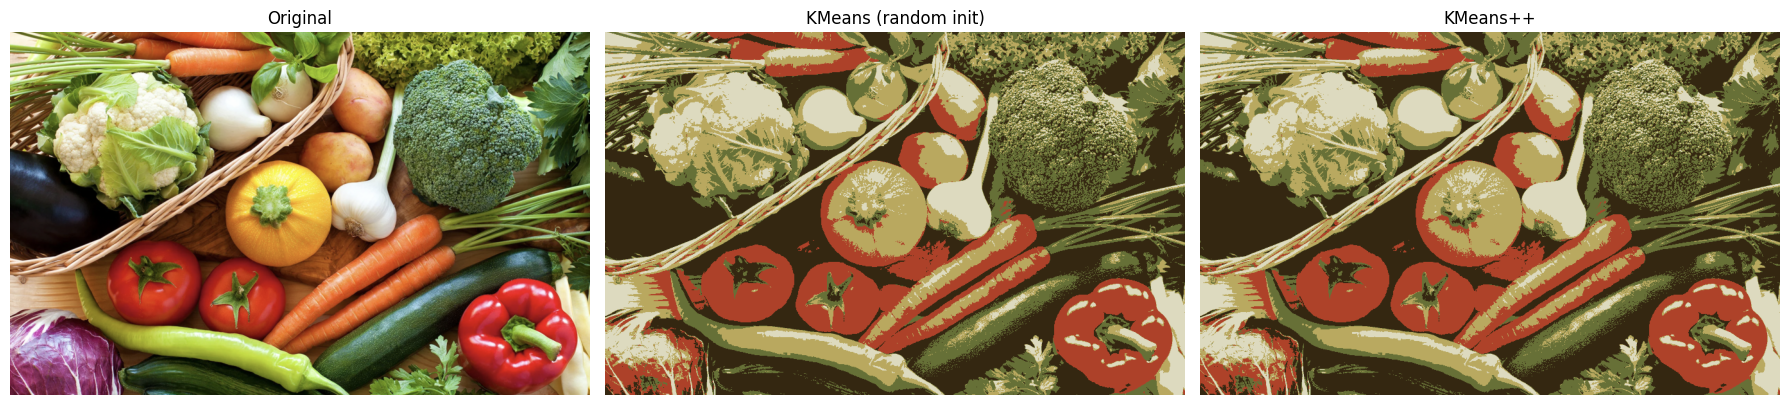

In [8]:
# Pixel clustering with KMeans (random) and KMeans++
# (safe to re-run)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from skimage.io import imread
from skimage.transform import rescale

# --- load & downscale image (0..1 float) ---
image = imread("image0.png")                # make sure image0.png is in Colab files
image = rescale(image, 0.5, channel_axis=-1)  # 50% size for speed

H, W, C = image.shape
pixels = image.reshape(-1, C).astype(np.float32)   # (N, 3)

# --- common params ---
k_colors = 5
params = dict(n_clusters=k_colors, n_init=10, max_iter=50, random_state=42)

# ----------------------------
# TODO Implement KMeans (random init)
# ----------------------------
kmeans_rand = KMeans(init="random", **params)
labels_rand = kmeans_rand.fit_predict(pixels)
centers_rand = kmeans_rand.cluster_centers_
quantized_rand = centers_rand[labels_rand].reshape(H, W, C)

# ----------------------------
# TODO KMeans++ (default smart init)
# ----------------------------
kmeans_pp = KMeans(init="k-means++", **params)
labels_pp = kmeans_pp.fit_predict(pixels)
centers_pp = kmeans_pp.cluster_centers_
quantized_pp = centers_pp[labels_pp].reshape(H, W, C)

# ----------------------------
# Visualization
# ----------------------------
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axes[0].imshow(image)
axes[0].set_title("Original");  axes[0].axis("off")

axes[1].imshow(np.clip(quantized_rand, 0, 1))
axes[1].set_title("KMeans (random init)");  axes[1].axis("off")

axes[2].imshow(np.clip(quantized_pp, 0, 1))
axes[2].set_title("KMeans++");  axes[2].axis("off")

plt.tight_layout(); plt.show()






## [TODO] Image Clustering (Instructions) (10 points)
1. Load each of the three images which should be given to you (image1.jpg, image2.jpg, image3.jpg)
2. For each image, apply **KMeans clustering** twice:  
   - **KMeans (Random Init)**  
   - **KMeans++ (Smart Init)**  
3. Replace each pixel with the color of its cluster centroid.  
   - This reduces the number of unique colors in the image.  
   - The result is a “posterized” image with simplified colors.  
4. Display the results in a **3×3 grid**:  
   - **Column 1** → Original images.  
   - **Column 2** → KMeans results.  
   - **Column 3** → KMeans++ results.  

You need to get the output as follows:
- A single figure with 9 panels (3 rows × 3 columns).  
- Each row corresponds to one image.  
- The leftmost image in each row is the original, followed by its KMeans and KMeans++ clustered versions.  
---


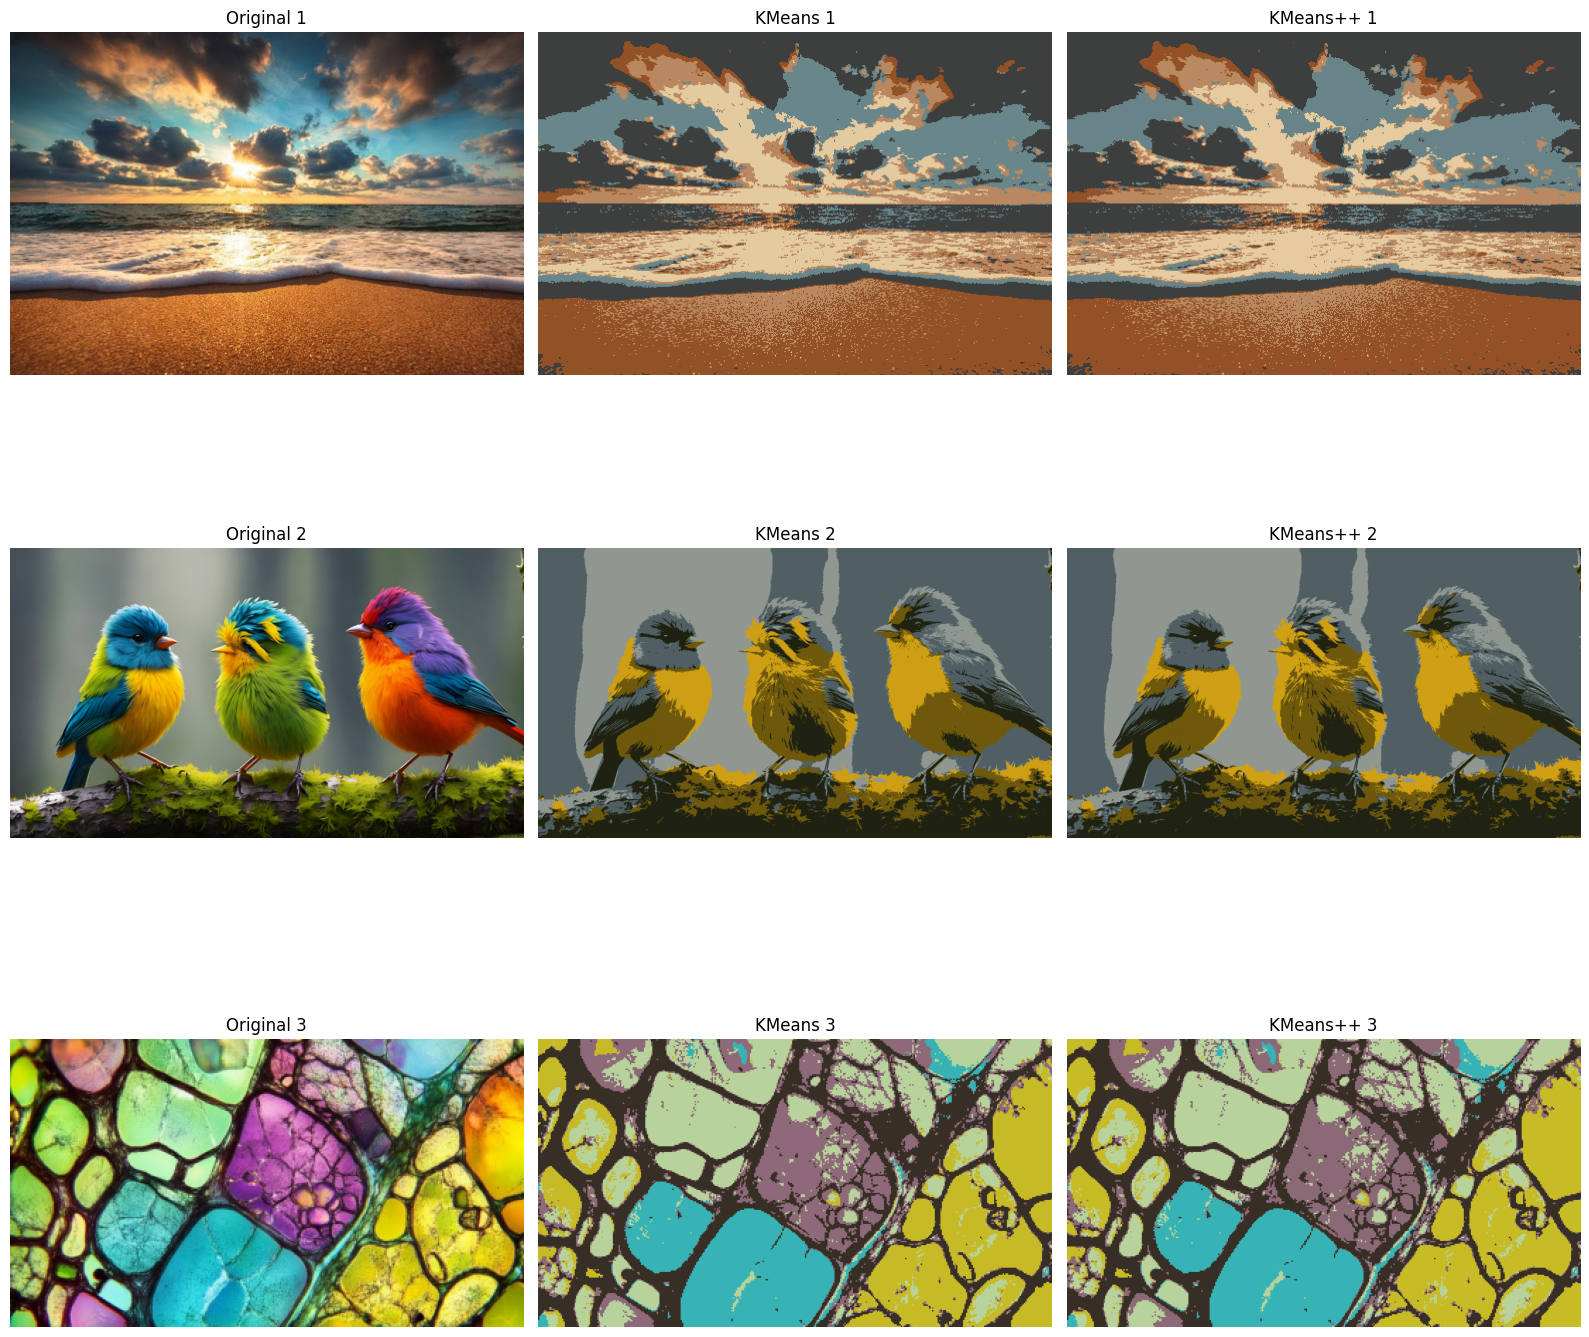

In [9]:
# 3-image pixel clustering with KMeans (random) and KMeans++
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import rescale
from sklearn.cluster import KMeans

def cluster_image(image_path, k=5, scale=0.5):
    # Load image as float in [0,1]; downscale for speed
    img = imread(image_path)
    img = rescale(img, scale, channel_axis=-1)          # keep channels last
    H, W, C = img.shape
    pixels = img.reshape(-1, C).astype(np.float32)      # (N,3)

    # ---- KMeans (random init) ----
    km_rand = KMeans(n_clusters=k, init="random", n_init=10, max_iter=50, random_state=42)
    labels_rand = km_rand.fit_predict(pixels)
    centers_rand = km_rand.cluster_centers_
    kmeans_image = centers_rand[labels_rand].reshape(H, W, C)

    # ---- KMeans++ (smart init) ----
    km_pp = KMeans(n_clusters=k, init="k-means++", n_init=10, max_iter=50, random_state=42)
    labels_pp = km_pp.fit_predict(pixels)
    centers_pp = km_pp.cluster_centers_
    kmeans_pp_image = centers_pp[labels_pp].reshape(H, W, C)

    # Clamp to [0,1] for display
    kmeans_image = np.clip(kmeans_image, 0, 1)
    kmeans_pp_image = np.clip(kmeans_pp_image, 0, 1)

    return img, kmeans_image, kmeans_pp_image

# Run on the three provided images
images = ["image1.jpg", "image2.jpg", "image3.jpg"]    # set k as needed (e.g., 5 or 6)
results = [cluster_image(p, k=5) for p in images]

# 3×3 grid: each row = (original, KMeans, KMeans++)
fig, axes = plt.subplots(3, 3, figsize=(16, 16))
for i, (orig, km_rand, km_pp) in enumerate(results):
    axes[i, 0].imshow(orig);     axes[i, 0].set_title(f"Original {i+1}"); axes[i, 0].axis("off")
    axes[i, 1].imshow(km_rand);  axes[i, 1].set_title(f"KMeans {i+1}");   axes[i, 1].axis("off")
    axes[i, 2].imshow(km_pp);    axes[i, 2].set_title(f"KMeans++ {i+1}"); axes[i, 2].axis("off")

plt.tight_layout(); plt.show()


# [TODO] Answer the following questions (8 points)

---

**1. Question:** What does the Silhouette Score of KMeans++ for MNIST dataset represent?  

**Answer:**  
It tells us how well the digit images are grouped into clusters. A higher score means points are closer to their own cluster and further from other clusters, so the clustering is better.
---

**2. Question:** When you used the KMeans library you set `n_init = 10`. What does `n_init` do?  

**Answer:**  
It means KMeans will run 10 times with different random starting points, and then pick the best result. This makes the final clusters more reliable.
---

**3. Question:** When you used the KMeans library you set `max_iter = 50`. What does `max_iter` do?  

**Answer:**  
It sets the maximum number of steps KMeans can take to move the centroids around. If it doesn’t settle earlier, it will stop after 50 steps.
---

**4. Question:** What distance metric did you use for computing the Silhouette score of KMedoids?  

**Answer:**  
For the silhouette score we used Euclidean distance, but when running KMedoids itself we used Manhattan (L1) distance.
---
